In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
import os
from tqdm.auto import tqdm
from sklearn import decomposition

import scipy.stats as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

from sklearn.ensemble import RandomForestClassifier

### Parameters

In [ ]:
# FOLDERS' PATHS

# path of original data folder
originalD_path = "/content/drive/MyDrive/Thesis/3rd_semester/Data/original"
# folder to save csv files for Force data for each subject individually instead of .txt files
csvD_path = "/content/drive/MyDrive/Thesis/3rd_semester/Data/csv_files"
# folder to save processed\transformed data
Processed_Data = "/content/drive/MyDrive/Thesis/3rd_semester/Data/Processed_data"

### Reading Force's Data

In [ ]:
columns = ['Time', 'L1' , 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 
            'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 
            'Total_Force_Left', 'Total_Force_Right']

In [ ]:
# reading given csv file 
# and creating dataframe
for name in os.listdir(originalD_path):
  if 'Co' in name or 'Pt' in name:
    df = pd.read_csv(originalD_path + "/" + name, header = None, sep='\t')
      
    # adding column headings
    df.columns = columns
      
    # store dataframe into csv file
    name = csvD_path + "/" + name.split('.')[0]+'.csv'
    df.to_csv(name, index = None)

### Visualization

In [ ]:
import matplotlib.pyplot as plt

Choosing 2 random subjects, one healthy and one with PD. Then visualize the measured total force for each foot over the 2 mins walk.

(1001, 19)
(1001, 19)


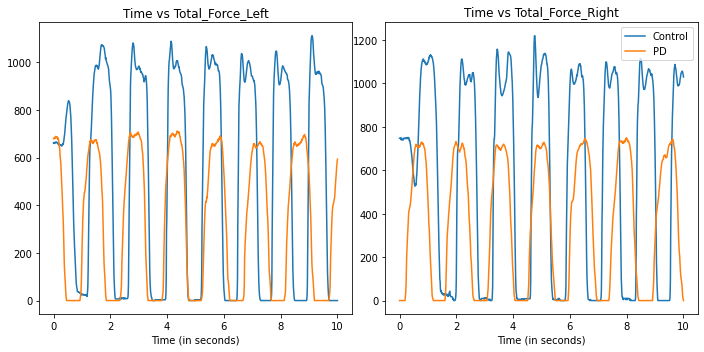

In [ ]:
pd_subject = 'GaPt03_01'
control_subject = 'GaCo01_01'

pd_df = pd.read_csv(csvD_path + "/"  + pd_subject + '.csv').head(1001)
control_df = pd.read_csv(csvD_path + "/" + control_subject + '.csv').head(1001)
print(pd_df.shape)
print(control_df.shape)

nrows = 1
ncols = 2

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
  plt.subplot(nrows, ncols, i+1)
  plt.tight_layout()
  plt.title("Time vs " + fname)
  plt.plot(control_df.Time, control_df[fname])
  plt.plot(pd_df.Time, pd_df[fname])
  plt.xlabel('Time (in seconds)')

plt.legend(["Control", "PD",]) 
plt.show()

Visualizing the measured total force for each foot for 4 random subjects. The first one is healthy, the 2nd suffer from PD with 2score, the 3rd with 2.5 score, the 4th with 3 score on HY PD scale.

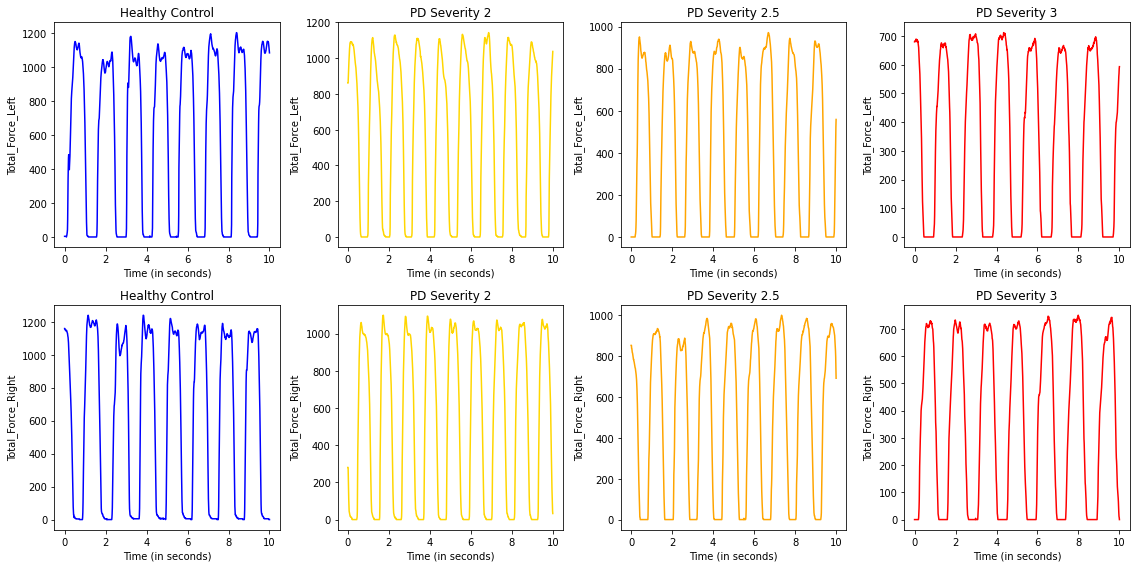

In [ ]:
nrows = 2
ncols = 4
subjects = ['GaCo03_01', 'GaPt06_01', 'GaPt04_01', 'GaPt03_01']
category = ['Healthy Control', 'PD Severity 2', 'PD Severity 2.5', 'PD Severity 3']
colors = ['blue', '#FFD600', 'orange', 'red']
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

i = 0
for sub in subjects:
  df = pd.read_csv(csvD_path + "/" + sub + '.csv').head(1001)
  i += 1
  for j, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
    plt.subplot(nrows, ncols, i + (j*4))
    plt.tight_layout()
    plt.plot(df.Time, df[fname], color=colors[i-1])
    plt.xlabel('Time (in seconds)')
    plt.ylabel(fname)
    plt.title(category[i-1])
    
plt.show()

### Reading demographic file

In [ ]:
# Reading demographic file
demographics = pd.read_csv(originalD_path+'/demographics.txt', delim_whitespace=True)

# Find the ids of subjects from demographics file
sub_id_dem = demographics.ID.to_list()

# Find the ids of subjects from Force files
sub_id_f = []
for name in os.listdir(csvD_path):
  sub_name = name.split('_')[0]
  sub_id_f.append(sub_name)

# Find the count of subjects from Force files
unique_subjects_f  = list(set(sub_id_f))

missing_subjects= np.setdiff1d(sub_id_dem,unique_subjects_f)
print("Subjects Count (in demographics) = ", len(sub_id_dem))
print("Force Files count = ", len(sub_id_f))
print (f"Subjects Count (in Force files) {len(unique_subjects_f)}")
print (f"Count of missing files from Force files: {len(missing_subjects)}, the ids of those are: {missing_subjects}")

Subjects Count (in demographics) =  166
Force Files count =  306
Subjects Count (in Force files) 165
Count of missing files from Force files: 1, the ids of those are: ['Juc010']


There is a subject with `Juc010` id that has demographics describtions and does not have measured force features while walking.

In [ ]:
# Remove the demographics of missing force file
demographics = demographics[demographics.ID != 'Juc010']

In [ ]:
# Checking the unique values of the HoehnYahr column in demographics file
demographics['HoehnYahr'].unique()

array([3. , 2.5, 2. , 0. , nan])

It turns out that the `NAN` values are given to some of the control group, those who will score 0 at HoehnYahr since they do not suffer from Parkinson's disease.
Thus, those `Nan` values can be replaced with zero. 

In [ ]:
demographics['HoehnYahr'] = demographics['HoehnYahr'].fillna(0)
demographics.HoehnYahr.value_counts()

0.0    72
2.0    55
2.5    28
3.0    10
Name: HoehnYahr, dtype: int64

There are 72 zero values, those are for Control Group. And we have 93 other scores belong to subjects with PD.

Let's save the edited demographics file.

In [ ]:
demographics

,ID,Study,Group,Subjnum,Gender,Age,Height,Weight,HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01,Speed_02,Speed_03,Speed_04,Speed_05,Speed_06,Speed_07,Speed_10
0,GaPt03,Ga,1,3,2,82,1.45,50.0,3.0,20.0,10.0,36.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778
1,GaPt04,Ga,1,4,1,68,1.71,NaN,2.5,25.0,8.0,11.00,0.642,NaN,NaN,NaN,NaN,NaN,NaN,0.818
2,GaPt05,Ga,1,5,2,82,1.53,51.0,2.5,24.0,5.0,14.50,0.908,NaN,NaN,NaN,NaN,NaN,NaN,0.614
3,GaPt06,Ga,1,6,1,72,1.70,82.0,2.0,16.0,13.0,10.47,0.848,NaN,NaN,NaN,NaN,NaN,NaN,0.937
4,GaPt07,Ga,1,7,2,53,1.67,54.0,3.0,44.0,22.0,18.34,0.677,0.957,NaN,NaN,NaN,NaN,NaN,0.579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,SiCo26,Si,2,26,1,60,1.74,72.0,0.0,NaN,NaN,9.20,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,SiCo27,Si,2,27,1,67,1.90,95.0,0.0,NaN,NaN,12.52,1.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,SiCo28,Si,2,28,1,61,1.70,72.0,0.0,NaN,NaN,12.65,0.990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,SiCo29,Si,2,29,1,53,1.70,87.0,0.0,NaN,NaN,11.41,1.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
demographics.to_csv(Processed_Data + '/demographics_HYprocessed.csv', index =False)

### Train-Test Data (Force + Demographics) Split

In [ ]:
train_path =Processed_Data + 'train'
test_path =Processed_Data + 'test'

count = len(os.listdir(csvD_path))
train_count = int(80/100*count)
test_count = count - train_count

print("Training Count Subjects = ", train_count)
print("Test Count Subjects = ", test_count)

category = 'train'
counter = 1

ypath = Processed_Data + '/y_' + category + '.txt'
yfile = open(ypath, "a")
hypath = Processed_Data + '/hyscore_' + category + '.txt'
hyfile = open(hypath, "a")

for name in os.listdir(csvD_path):
  if counter == train_count + 1:
    yfile.flush()
    yfile.close()
    hyfile.flush()
    hyfile.close()
    
    category = 'test'    
    ypath = Processed_Data + '/y_' + category + '.txt'
    yfile = open(ypath, "a")
    hypath = Processed_Data + '/hyscore_' + category + '.txt'
    hyfile = open(hypath, "a")
  print(counter, name, category)
  
  sub_name = name.split('_')[0]
  sub_class = demographics[demographics['ID'] == sub_name]['Group'].to_string(index=False).strip()
  hy_class = demographics[demographics['ID'] == sub_name]['HoehnYahr'].to_string(index=False).strip()
  sub_data = pd.read_csv(csvD_path + '/' + name)
  features = sub_data.columns.to_list()

  full_size = 2
  overlap = 0.5
  overlap_size = int(full_size * overlap / 2)
  entry_size = full_size - overlap_size
  
  for i in range(0, sub_data.shape[0], entry_size):
    if sub_data.shape[0] >= i + entry_size + overlap_size:
      yfile.write(sub_class + "\n")
      hyfile.write(hy_class + "\n")
      
      for fname in features:
        path_name = Processed_Data+'/' + category + '/'
        file_name = fname + '_' + category + '.txt'
        with open(path_name + file_name, 'a') as feat_file:
          arr = sub_data.iloc[i:i + entry_size + overlap_size, ][fname].to_numpy()
          # print(i, len(arr), end = ' | ')
          feat_file.write(' '.join(map(str, arr)) + "\n")

  counter = counter + 1
yfile.flush()
yfile.close()
hyfile.flush()
yfile.close()

### Calculating statical data

In [ ]:
# loop over the csv files of Force data and calculate static values for each feature 

# lists for the files' names for the two cases : Parkinson's D and Control data
files_co = []
files_pt = []

# Getting the files names for PD and control
for name in os.listdir(csvD_path):
    if 'Co' in name:
        files_co.append(csvD_path+'/' + name)
    elif 'Pt' in name:
        files_pt.append(csvD_path+'/' + name)


# paths where to save static data
co_st_path = Processed_Data + '/Co_statical.csv'
pt_st_path = Processed_Data + '/Pt_statical.csv'

In [ ]:
static_co_df = pd.DataFrame()
for i,file in enumerate(tqdm(files_co)):
    #global df, static_co_df

    df = pd.read_csv(file)
    for col in df.columns:
        for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
            colname = col +'_' +  x
            if x == 'Min':
                static_co_df.loc[i, colname] = df[col].min(axis=0)
                
            if x == 'Max':
                static_co_df.loc[i, colname] = df[col].max(axis=0)
                
            if x == 'Std':
                static_co_df.loc[i, colname] = df[col].std(axis=0)
                
            if x == 'Med':
                static_co_df.loc[i, colname] = df[col].median(axis=0)
                
            if x == 'Avg':
                static_co_df.loc[i, colname] = df[col].mean(axis=0)
            if x == 'Skewness':
                static_co_df.loc[i, colname] = df[col].skew(axis=0)
                
            if x == 'Kurtosis':
                static_co_df.loc[i, colname] = df[col].kurtosis(axis=0)

  0%|          | 0/92 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [ ]:
static_co_df.to_csv(co_st_path, index = False)

In [ ]:
static_pt_df = pd.DataFrame()
for i,file in enumerate(tqdm(files_pt)):
    #global df, static_co_df

    df = pd.read_csv(file)
    for col in df.columns:
        for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
            colname = col +'_' +  x
            if x == 'Min':
                static_pt_df.loc[i, colname] = df[col].min(axis=0)
                
            if x == 'Max':
                static_pt_df.loc[i, colname] = df[col].max(axis=0)
                
            if x == 'Std':
                static_pt_df.loc[i, colname] = df[col].std(axis=0)
                
            if x == 'Med':
                static_pt_df.loc[i, colname] = df[col].median(axis=0)
                
            if x == 'Avg':
                static_pt_df.loc[i, colname] = df[col].mean(axis=0)
            if x == 'Skewness':
                static_pt_df.loc[i, colname] = df[col].skew(axis=0)
                
            if x == 'Kurtosis':
                static_pt_df.loc[i, colname] = df[col].kurtosis(axis=0)

  0%|          | 0/214 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [ ]:
static_pt_df.to_csv(pt_st_path, index = False)

### Reading statical data

In [ ]:
# paths where to read static data
co_st_path = Processed_Data + '/Co_statical.csv'
pt_st_path = Processed_Data + '/Pt_statical.csv'

In [ ]:
static_pt_df = pd.read_csv(pt_st_path)

In [ ]:
static_pt_df

,Time_Min,Time_Max,Time_Std,Time_Med,Time_Avg,Time_Skewness,Time_Kurtosis,L1_Min,L1_Max,L1_Std,...,Total_Force_Left_Avg,Total_Force_Left_Skewness,Total_Force_Left_Kurtosis,Total_Force_Right_Min,Total_Force_Right_Max,Total_Force_Right_Std,Total_Force_Right_Med,Total_Force_Right_Avg,Total_Force_Right_Skewness,Total_Force_Right_Kurtosis
0,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,106.92,27.669679,...,343.433216,-0.052469,-1.687438,0.0,785.40,301.697231,395.01,364.761489,-0.028738,-1.686813
1,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,302.72,36.389051,...,472.857451,-0.118487,-1.828238,0.0,1000.56,415.672494,545.49,480.988247,-0.066158,-1.816188
2,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,188.32,33.043802,...,363.901857,0.011314,-1.722580,0.0,922.79,358.410486,587.29,405.510439,-0.108921,-1.833495
3,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,308.55,100.189524,...,465.003393,-0.059392,-1.732254,0.0,1008.70,395.816662,565.62,488.193515,-0.109725,-1.703317
4,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,316.36,63.709001,...,485.447690,-0.206446,-1.586145,0.0,1192.62,397.039576,445.17,445.053855,0.155510,-1.545189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,302.17,56.161618,...,428.969820,-0.088808,-1.707781,0.0,917.29,339.372594,544.61,422.322767,-0.188193,-1.682274
210,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,360.69,73.349271,...,619.404817,-0.000162,-1.647349,0.0,1303.72,453.807966,647.68,533.579121,-0.004403,-1.673542
211,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,405.79,135.177625,...,565.171078,-0.049955,-1.750190,0.0,1182.61,450.440619,597.52,546.551061,-0.078488,-1.716723
212,0.0,121.1715,34.983534,60.5858,60.585759,4.286546e-09,-1.2,0.0,401.83,107.402565,...,494.790293,-0.036889,-1.744017,0.0,1151.15,396.927345,621.06,473.149084,-0.123022,-1.699132


In [ ]:
static_co_df = pd.read_csv(co_st_path)

#### combining statical data (PD, Control) into one

In [ ]:
X = pd.concat([static_co_df, static_pt_df])

In [ ]:
# labels considering 0 for control and 1 for PD
y_co = pd.Series([0]*(static_co_df.shape[0]))
y_pt = pd.Series([1]*(static_pt_df.shape[0]))
y = pd.concat([y_co,y_pt]) 

#### Split statical data into Train/Test

In [ ]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(229, 133)
(77, 133)
(229, 1)
(77, 1)


### Applying SVC over all features from statical data

In [ ]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
for gamma in ([0.01, 1, 5]):
    
    for c in ([0.1, 1, 15, 250]):
         
        clf = SVC(kernel = 'rbf', gamma = gamma, C = c).fit(X_train, y_train)
        print('gamma = {:.2f}, C = {:.2f}, accuracy = {}'.format(gamma, c, clf.score(X_test, np.ravel(y_test))))
        

gamma = 0.01, C = 0.10, accuracy = 0.5974025974025974
gamma = 0.01, C = 1.00, accuracy = 0.5974025974025974
gamma = 0.01, C = 15.00, accuracy = 0.7662337662337663
gamma = 0.01, C = 250.00, accuracy = 0.7922077922077922
gamma = 1.00, C = 0.10, accuracy = 0.5974025974025974
gamma = 1.00, C = 1.00, accuracy = 0.7142857142857143
gamma = 1.00, C = 15.00, accuracy = 0.7532467532467533
gamma = 1.00, C = 250.00, accuracy = 0.7532467532467533
gamma = 5.00, C = 0.10, accuracy = 0.5974025974025974
gamma = 5.00, C = 1.00, accuracy = 0.6103896103896104
gamma = 5.00, C = 15.00, accuracy = 0.6363636363636364
gamma = 5.00, C = 250.00, accuracy = 0.6363636363636364


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

### Applying KNN for all features from statical dataset

In [ ]:
X_train, X_test, y_train1, y_test1 = train_test_split(X, y, random_state = 900)
y_train = pd.DataFrame(y_train1)
y_test = pd.DataFrame(y_test1)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

train_score=[]
test_score=[]
for neighbors in ([1, 3, 5, 10, 15, 20]):
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(X_train, np.ravel(y_train,order='C'))
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))

for neighbor, tr_sc , test_sc in zip(([1, 3, 5, 10, 15, 20]),train_score, test_score): 
    print(f"Neighbors = {neighbor}")
    print('Accuracy of K-NN classifier on training set: {:.2f}'.format(tr_sc))
    print('Accuracy of K-NN classifier on test set: {:.2f}'.format(test_sc))
    print()

Neighbors = 1
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.88

Neighbors = 3
Accuracy of K-NN classifier on training set: 0.93
Accuracy of K-NN classifier on test set: 0.84

Neighbors = 5
Accuracy of K-NN classifier on training set: 0.92
Accuracy of K-NN classifier on test set: 0.84

Neighbors = 10
Accuracy of K-NN classifier on training set: 0.87
Accuracy of K-NN classifier on test set: 0.79

Neighbors = 15
Accuracy of K-NN classifier on training set: 0.83
Accuracy of K-NN classifier on test set: 0.82

Neighbors = 20
Accuracy of K-NN classifier on training set: 0.82
Accuracy of K-NN classifier on test set: 0.81



In [ ]:
# for model with 15 neighbors
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, np.ravel(y_train,order='C'))
train_score.append(knn.score(X_train, y_train))
test_score.append(knn.score(X_test, y_test))
prediction = knn.predict(X_test)

In [ ]:
prec = precision_score(y_test1, prediction)
rec = recall_score(y_test1, prediction)
f1 = f1_score(y_test1, prediction)
print("Precision: {}".format(prec))
print("Recall: {}".format(rec))
print("F1: {}".format(f1))

Precision: 0.8214285714285714
Recall: 0.92
F1: 0.8679245283018867


### Random forest classifier


In [ ]:
test_score_RFC=[]

X_train, X_test, y_train1, y_test1 = train_test_split(X, np.ravel(y),random_state=64)
y_train = pd.DataFrame(y_train1)
y_test = pd.DataFrame(y_test1)

for n in [5, 10, 20, 40, 100, 200]:
    clf = RandomForestClassifier(n_estimators = int(n), n_jobs=2)
    clf.fit(X_train, np.ravel(y_train))
    acc = clf.score(X_test, np.ravel(y_test))
    test_score_RFC.append(acc)

In [ ]:
for neighbor, tr_sc in zip(([5, 10, 20, 40, 100, 200]),test_score_RFC): 
    print(f"Estimator = {neighbor}")
    print('Accuracy of Random Forest Classifier on training set: {:.2f}'.format(tr_sc))

Estimator = 5
Accuracy of Random Forest Classifier on training set: 0.88
Estimator = 10
Accuracy of Random Forest Classifier on training set: 0.96
Estimator = 20
Accuracy of Random Forest Classifier on training set: 0.92
Estimator = 40
Accuracy of Random Forest Classifier on training set: 0.97
Estimator = 100
Accuracy of Random Forest Classifier on training set: 0.95
Estimator = 200
Accuracy of Random Forest Classifier on training set: 0.97


In [ ]:
prediction_clf = clf.predict(X_test)
prec = precision_score(y_test1, prediction_clf)
rec = recall_score(y_test1, prediction_clf)
f1 = f1_score(y_test1, prediction_clf)
print("Precision: {}".format(prec))
print("Recall: {}".format(rec))
print("F1: {}".format(f1))

Precision: 0.9818181818181818
Recall: 0.9818181818181818
F1: 0.9818181818181818
